In [6]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import math

RESHAPED = 1
NB_CLASSES = 1
DROPOUT = 0.3
N_HIDDEN = 512
BATCH_SIZE = 15
EPOCHS = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

DATA_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
LABEL_COLUMN = 'total_deaths'
    
file_path = tf.keras.utils.get_file("owid-covid-data.csv", DATA_URL)

SELECT_COLUMNS = ['iso_code', 'total_cases', 'total_deaths']
DEFAULTS = ['', 0.0, 0.0]

def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=1, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      shuffle=True,
      **kwargs)
    return dataset

covid_dataset = get_dataset(file_path, select_columns=SELECT_COLUMNS, column_defaults = DEFAULTS)
            
def convert_to_train_test_data(dataset, test_percent = 0.05):
    total_deaths = []
    total_cases = []
    for independent, dependent in dataset.as_numpy_iterator():
        if independent.get('iso_code')[0] == b'USA':
            total_deaths.append(dependent[0])
            total_cases.append([independent.get('total_cases')[0]])
    testRecordCount = int(round(test_percent*len(total_deaths)))
    return total_cases[testRecordCount:], total_deaths[testRecordCount:], total_cases[:testRecordCount], total_deaths[:testRecordCount]
    
x_train, y_train, x_test, y_test = convert_to_train_test_data(covid_dataset, test_percent=0.05)


features = ['total_cases']


Train on 86 samples, validate on 22 samples
Epoch 1/20
86/86 [==============================] - 2s 27ms/sample - loss: 5141592738.0843 - accuracy: 0.3488 - val_loss: 92087748.3636 - val_accuracy: 0.3182
Epoch 2/20
86/86 [==============================] - 0s 2ms/sample - loss: 107294293.7616 - accuracy: 0.3605 - val_loss: 469488439.2727 - val_accuracy: 0.2727
Epoch 3/20
86/86 [==============================] - 0s 2ms/sample - loss: 151936568.8757 - accuracy: 0.3372 - val_loss: 23058607.9545 - val_accuracy: 0.5455
Epoch 4/20
86/86 [==============================] - 0s 1ms/sample - loss: 219850603.4186 - accuracy: 0.3837 - val_loss: 5313109.8636 - val_accuracy: 0.4545
Epoch 5/20
86/86 [==============================] - 0s 1ms/sample - loss: 206904240.4884 - accuracy: 0.3488 - val_loss: 54011118.3636 - val_accuracy: 0.3182
Epoch 6/20
86/86 [==============================] - 0s 2ms/sample - loss: 417336062.1570 - accuracy: 0.3140 - val_loss: 100423192.0000 - val_accuracy: 0.3182
Epoch 7/20


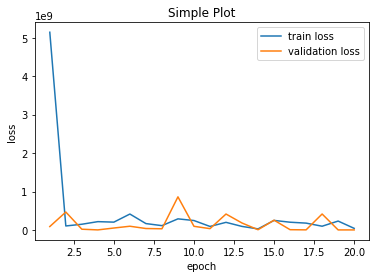

In [9]:
opt = keras.optimizers.RMSprop(learning_rate=0.001)

model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, input_shape=(RESHAPED,), name='input_dense_layer',activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(N_HIDDEN, name='hidden_dense_layer',activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(NB_CLASSES, name='output_dense_layer'))

model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

history = model.fit(np.array(x_train), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test))
print()
print('Test accuracy:', test_acc)

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(validation_loss)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(epochs, train_loss, label='train loss')
ax.plot(epochs, validation_loss, label='validation loss')
ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend() 


[[43446.613]]


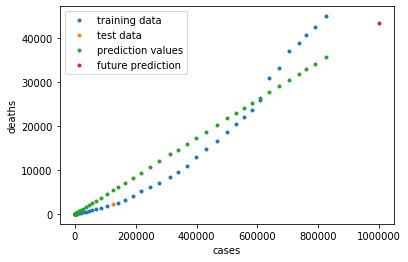

In [10]:
CASE_COUNT = 1000000
FUTURE_CASES = [CASE_COUNT]
FUTURE_PREDICTION = []

PREDICTED_CASES = []
PREDICTED_DEATHS = []

pred_traning_deaths = model.predict(np.array(x_train))

count = 0
for deaths in pred_traning_deaths:
    PREDICTED_CASES.append(x_train[count])
    PREDICTED_DEATHS.append(deaths)
    count += 1

pred_validation_deaths = model.predict(np.array(x_test))

count = 0
for deaths in pred_validation_deaths:
    PREDICTED_CASES.append(x_test[count])
    PREDICTED_DEATHS.append(deaths)
    count += 1

pred_deaths = model.predict(FUTURE_CASES)

for deaths in pred_deaths:
    FUTURE_PREDICTION.append(deaths)
    
print(pred_deaths)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x_train, y_train, label='training data', linewidth=0, marker='.')
ax.plot(x_test, y_test, label='test data', linewidth=0, marker='.')
ax.plot(PREDICTED_CASES, PREDICTED_DEATHS, label='prediction values', linewidth=0, marker='.')
ax.plot(FUTURE_CASES, FUTURE_PREDICTION, label='future prediction', linewidth=0, marker='.')
ax.set_xlabel('cases')  # Add an x-label to the axes.
ax.set_ylabel('deaths')  # Add a y-label to the axes.
ax.legend() 

